In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
%matplotlib inline
gamma = 1

epsilon = 1
epsilon_dec = 1/3000

greedy_round_epsilon = 1.0 / 20

alpha = 0.2
alpha_after_top = 0.05

beta = 0.7
beta_dec = 0.7/2000

_lambda = 0.8

top_reached = False

shape = (30, 20, 10)
env = gym.make('MountainCarContinuous-v0')


class Holder:
    def __init__(self):
        self.Q = np.full(shape=shape, fill_value=0.0, dtype=np.float32)
        self.theta = np.full(shape=shape, fill_value=1.0/shape[2], dtype=np.float32)


def _get_action_value_from_index(actions_ind):
    lowest_action_of_index = actions_ind/5.0 - 1
    avg_action_of_index = lowest_action_of_index + 0.1
    return avg_action_of_index


def _get_indexes(state, action=None):
    pos_ind = (state[0] + 1.2) * 10
    vel_ind = (state[1] + 0.07) * 200
    if action:
        action_ind = (action+1) * 5
        if int(action_ind) > 9:
            print("action: {}".format(action))
            raise
        return int(vel_ind), int(pos_ind), int(action_ind)
    return int(vel_ind), int(pos_ind)


def get_Q_value_function(Q, state, action):
    return _get_value_func(Q, state, action)


def get_theta_value_function(theta, state, action=None):
    """if action=None, return array of all actions of state"""
    return _get_value_func(theta, state, action)


def update_theta_value_function(theta, state, action=None, value=None):
    """if action=None, value should be an array
     containing values for all actions in this state"""
    _update_value_func(theta, state, action, value)


def update_Q_value_function(Q, state, action, value):
    _update_value_func(Q, state, action, value)


def _get_value_func(obj, s, a):
    if a is not None:
        vel_ind, pos_ind, action_ind = _get_indexes(s, a)
        return obj[vel_ind, pos_ind, action_ind]
    else:
        vel_ind, pos_ind = _get_indexes(s)
        return obj[vel_ind, pos_ind, :]


def _update_value_func(obj, s, a, val):
    if a is not None:
        vel_ind, pos_ind, action_ind = _get_indexes(s, a)
        obj[vel_ind, pos_ind, action_ind] = val
    else:
        vel_ind, pos_ind = _get_indexes(s)
        obj[vel_ind, pos_ind, :] = val


def get_policy_gradient_vector(holder, state, action):
    """ decision_direction:
    -> positive towards the action made
    > negative towards all other actions,
    with proportion to their strength (probability)
    """
    vel_ind, pos_ind, action_ind = _get_indexes(state, action)
    action_direction_vector = np.full(shape=(10,), fill_value=0.0, dtype=np.float32)
    action_direction_vector[action_ind] = 1
    actions_probability = get_actions_probability(holder, state)
    decision_direction = action_direction_vector - actions_probability
    return decision_direction


def get_advantage_function(holder, state, action):
    actions_probability = get_actions_probability(holder, state)
    vel_ind, pos_ind, action_ind = _get_indexes(state, action)
    actions_value = holder.Q[vel_ind, pos_ind, :]
    expectancy_reward_from_state = actions_probability @ actions_value
    reward_from_state_action = get_Q_value_function(holder.Q, state, action)
    action_advantage = reward_from_state_action - expectancy_reward_from_state
    return action_advantage


def add_to_E(E, state, action, to_add):
    vel_ind, pos_ind, action_ind = _get_indexes(state, action)
    E[vel_ind, pos_ind, action_ind] += to_add


def get_actions_probability(holder, state):
    vel_ind, pos_ind = _get_indexes(state)
    actions = holder.theta[vel_ind, pos_ind, :]
    actions = actions.astype(np.float128)
    _restrict_actions(holder.theta, actions, vel_ind, pos_ind)   # to prevent overflow of exp(theta)

    actions_e = np.exp2(actions)
    normalized_actions_e = actions_e / np.sum(actions_e)

    return normalized_actions_e.astype(np.float32)


def _restrict_actions(theta, actions, vel_ind, pos_ind):
    _max = np.amax(actions)

    if _max > 1000:
        actions -= _max

    _max = 0
    _min = np.amin(actions)
    while abs(_max - _min) > 1000:

        if np.any(actions == -np.inf):
            min_not_inf = np.min([x for x in actions if x != -np.inf])
            inf_indexes = np.where(actions == -np.inf)[0]
            for ind in inf_indexes:
                actions[ind] = min_not_inf
            theta[vel_ind, pos_ind, :] = actions

        actions /= 1000
        _min /= 1000
        _max /= 1000

    reduced_actions = actions.astype(np.float32)
    theta[vel_ind, pos_ind, :] = reduced_actions


def sample_action_from_soft_max_policy(holder, state):
    actions_probability = get_actions_probability(holder, state)
    partition_of_01 = np.cumsum(actions_probability)
    partition_of_01 += (1 - np.amax(partition_of_01))  # to ensure last element is exactly 1
    r = np.random.random()
    action_ind = np.digitize(r, partition_of_01)
    return _get_action_value_from_index(action_ind)


def _random_action():
    return np.random.random()*2 - 1  # uniform(-1,1)


def epsilon_sample_action_from_soft_max_policy(holder, state):
    if np.random.random() < epsilon:
        return _random_action()
    else:
        return sample_action_from_soft_max_policy(holder, state)


def act(action):
    next_state, reward, done, _ = env.step([action])
    return next_state, reward, done


def tune_params(total_reward):
    global alpha, beta, epsilon, top_reached
    epsilon = max(0.05, epsilon - epsilon_dec)

    reward_threshold = 10
    if total_reward > reward_threshold and not top_reached:
        top_reached = True
        alpha = alpha_after_top  # theta

    if top_reached:
        beta = max(0.05, beta - beta_dec)  # Q


def learn(holder, num_episodes, do_greedy_round=False):
    for episode in range(1, num_episodes + 1):
        E = np.zeros(shape=shape)
        state = env.reset()
        episode_done = False
        steps_counter = 0
        total_reward = 0

        is_greedy_round = False
        if do_greedy_round:
            is_greedy_round = np.random.random() < greedy_round_epsilon

        if is_greedy_round:
            action_sampler = sample_action_from_soft_max_policy
        else:
            action_sampler = epsilon_sample_action_from_soft_max_policy

        action = action_sampler(holder, state)
        while not episode_done:
            if steps_counter > 200:
                break
            steps_counter += 1

            next_state, reward, episode_done = act(action)
            total_reward += reward

            next_action = action_sampler(holder, state)

            delta = reward + \
                    gamma * get_Q_value_function(holder.Q, next_state, next_action) \
                    - get_Q_value_function(holder.Q, state, action)

            # theta
            policy_gradient_vector = get_policy_gradient_vector(holder, state, action)
            action_advantage_scalar = get_advantage_function(holder, state, action)
            theta_state_update = alpha * policy_gradient_vector * action_advantage_scalar
            theta_state = get_theta_value_function(holder.theta, state)
            update_theta_value_function(holder.theta, state, action=None,
                                        value=theta_state + theta_state_update)
            # w
            add_to_E(E, state, action, 1)
            holder.Q = np.add(holder.Q, np.multiply(beta * delta, E))
            E = np.multiply(gamma * _lambda, E)

            state = next_state
            action = next_action

        tune_params(total_reward)


def test(holder, num_of_tests=10):
    rewards = []
    for _ in range(num_of_tests):
        state = env.reset()
        episode_done = False
        steps_counter = 0
        total_reward = 0
        while not episode_done:
            if steps_counter > 200:
                break
            steps_counter += 1

            action = sample_action_from_soft_max_policy(holder, state)
            next_state, reward, episode_done = act(action)
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return np.average(rewards), np.var(rewards)


def plot_test(num_trials, rewards, _vars):
    _vars = [pow(x, 0.5) for x in _vars]
    plt.errorbar(num_trials, rewards, yerr=_vars, linestyle='None', marker='o')
    plt.grid()
    plt.title("reward over num of trials")
    plt.xlabel('num of trials')
    plt.ylabel('avg. reward over 10 examples')
    plt.savefig("reward_over_examples.png")
    plt.show()


def plot_Q(Q):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    Q1 = np.zeros((30, 20))
    for j in range(30):
        for i in range(20):
            Q1[j, i] = np.amax(Q[j, i, :])

    X = np.arange(-0.6, 0.6, 0.06)
    Y = np.arange(-0.6, 1.2, 0.06)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, Q1, linewidth=0, antialiased=False)
    plt.show()


  3%|▎         | 1/30 [00:02<01:20,  2.79s/it]

000 | avg reward is: -6.655   |   epsilon: 0.8813   |  alpha: 0.2   |  beta: 0.7


  7%|▋         | 2/30 [00:05<01:18,  2.81s/it]

100 | avg reward is: -6.888   |   epsilon: 0.848   |  alpha: 0.2   |  beta: 0.7


 10%|█         | 3/30 [00:08<01:17,  2.85s/it]

200 | avg reward is: -6.679   |   epsilon: 0.8147   |  alpha: 0.2   |  beta: 0.7


 13%|█▎        | 4/30 [00:11<01:15,  2.89s/it]

300 | avg reward is: -6.884   |   epsilon: 0.7813   |  alpha: 0.2   |  beta: 0.7


 17%|█▋        | 5/30 [00:14<01:13,  2.92s/it]

400 | avg reward is: -6.908   |   epsilon: 0.748   |  alpha: 0.2   |  beta: 0.7


 20%|██        | 6/30 [00:17<01:11,  2.97s/it]

500 | avg reward is: -6.907   |   epsilon: 0.7147   |  alpha: 0.2   |  beta: 0.7


 23%|██▎       | 7/30 [00:20<01:09,  3.02s/it]

600 | avg reward is: -6.436   |   epsilon: 0.6813   |  alpha: 0.2   |  beta: 0.7


 27%|██▋       | 8/30 [00:24<01:07,  3.08s/it]

700 | avg reward is: -6.753   |   epsilon: 0.648   |  alpha: 0.2   |  beta: 0.7


 30%|███       | 9/30 [00:27<01:05,  3.14s/it]

800 | avg reward is: -7.088   |   epsilon: 0.6147   |  alpha: 0.2   |  beta: 0.7


 33%|███▎      | 10/30 [00:30<01:03,  3.18s/it]

900 | avg reward is: -7.106   |   epsilon: 0.5813   |  alpha: 0.2   |  beta: 0.7


 37%|███▋      | 11/30 [00:33<01:01,  3.23s/it]

1000 | avg reward is: -7.25   |   epsilon: 0.548   |  alpha: 0.2   |  beta: 0.7


 40%|████      | 12/30 [00:37<00:59,  3.29s/it]

1100 | avg reward is: -5.963   |   epsilon: 0.5147   |  alpha: 0.05   |  beta: 0.6699


 43%|████▎     | 13/30 [00:40<00:56,  3.34s/it]

1200 | avg reward is: -7.46   |   epsilon: 0.4813   |  alpha: 0.05   |  beta: 0.6349


 47%|████▋     | 14/30 [00:44<00:54,  3.40s/it]

1300 | avg reward is: 2.996   |   epsilon: 0.448   |  alpha: 0.05   |  beta: 0.5999


 50%|█████     | 15/30 [00:47<00:51,  3.45s/it]

1400 | avg reward is: 3.128   |   epsilon: 0.4147   |  alpha: 0.05   |  beta: 0.5649


 53%|█████▎    | 16/30 [00:51<00:48,  3.48s/it]

1500 | avg reward is: -6.809   |   epsilon: 0.3813   |  alpha: 0.05   |  beta: 0.5299


 57%|█████▋    | 17/30 [00:55<00:45,  3.53s/it]

1600 | avg reward is: 3.064   |   epsilon: 0.348   |  alpha: 0.05   |  beta: 0.4949


 60%|██████    | 18/30 [00:58<00:42,  3.57s/it]

1700 | avg reward is: -6.975   |   epsilon: 0.3147   |  alpha: 0.05   |  beta: 0.4599


 63%|██████▎   | 19/30 [01:02<00:39,  3.63s/it]

1800 | avg reward is: -6.974   |   epsilon: 0.2813   |  alpha: 0.05   |  beta: 0.4249


 67%|██████▋   | 20/30 [01:06<00:36,  3.68s/it]

1900 | avg reward is: -7.173   |   epsilon: 0.248   |  alpha: 0.05   |  beta: 0.3899


 70%|███████   | 21/30 [01:10<00:33,  3.73s/it]

2000 | avg reward is: 23.263   |   epsilon: 0.2147   |  alpha: 0.05   |  beta: 0.3549


 73%|███████▎  | 22/30 [01:13<00:29,  3.69s/it]

2100 | avg reward is: 93.802   |   epsilon: 0.1813   |  alpha: 0.05   |  beta: 0.3199


 77%|███████▋  | 23/30 [01:16<00:24,  3.50s/it]

2200 | avg reward is: 83.931   |   epsilon: 0.148   |  alpha: 0.05   |  beta: 0.2849


 80%|████████  | 24/30 [01:19<00:19,  3.31s/it]

2300 | avg reward is: 94.783   |   epsilon: 0.1147   |  alpha: 0.05   |  beta: 0.2499


 83%|████████▎ | 25/30 [01:22<00:15,  3.13s/it]

2400 | avg reward is: 95.507   |   epsilon: 0.0813   |  alpha: 0.05   |  beta: 0.2149


 87%|████████▋ | 26/30 [01:24<00:11,  2.90s/it]

2500 | avg reward is: 95.321   |   epsilon: 0.05   |  alpha: 0.05   |  beta: 0.1799


 90%|█████████ | 27/30 [01:27<00:08,  2.73s/it]

2600 | avg reward is: 95.544   |   epsilon: 0.05   |  alpha: 0.05   |  beta: 0.1449


100%|██████████| 30/30 [01:29<00:00,  2.98s/it]

2700 | avg reward is: 95.345   |   epsilon: 0.05   |  alpha: 0.05   |  beta: 0.1099
2800 | avg reward is: 95.189   |   epsilon: 0.05   |  alpha: 0.05   |  beta: 0.1099
2900 | avg reward is: 95.129   |   epsilon: 0.05   |  alpha: 0.05   |  beta: 0.1099


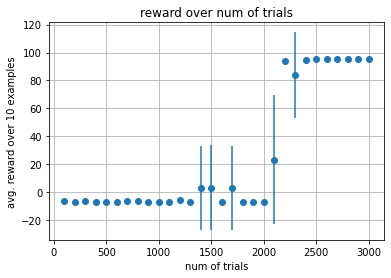

In [5]:
holder = Holder()
rewards = []
_vars = []
learn_periods = np.full(30, 100).tolist()

do_learn = True
consecutive_times_goal_reached = 0
for i in tqdm(range(len(learn_periods))):
    learn_period = learn_periods[i]
    do_greedy_round = True if i > 12 else False
    # do_greedy_round = True if top_reached else False
    if do_learn:
        learn(holder, learn_period, do_greedy_round=do_greedy_round)

    reward, var = test(holder)

    print("{}00 | avg reward is: {}   |   epsilon: {}   |  alpha: {}   |  beta: {}".format(
        i, np.round(reward, 3), np.round(epsilon, 4), np.round(alpha, 4), np.round(beta, 4)))

    rewards.append(reward)
    _vars.append(var)

    if reward > 90:
        consecutive_times_goal_reached += 1
    else:
        consecutive_times_goal_reached = 0

    if consecutive_times_goal_reached >= 5:
        do_learn = False

plot_test(np.cumsum(learn_periods), rewards, _vars)

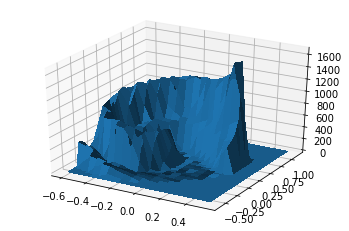

In [6]:
plot_Q(holder.Q)